# First model
The goal of this model is to establish the pattern of importing image data and building a simple model.

Model performance is not a priority, that comes later.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy import misc
import matplotlib.pyplot as plt
from skimage.transform import resize

## Get data

In [2]:
IMAGE_PATH = 'data/images/capture/'

In [3]:
data = pd.DataFrame.from_csv('data/labels/rugby_image_labels_2.csv')

In [4]:
data.head()

,y
file_name,
1491257473.62.jpg,327.0
1491257474.29.jpg,336.0
1491257474.83.jpg,367.0
1491257475.45.jpg,392.0
1491257476.09.jpg,401.0


In [5]:
test_img = misc.imread(IMAGE_PATH + data.iloc[0].name,flatten=True)

In [6]:
test_img.shape

(480, 640)

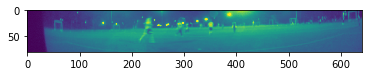

In [7]:
plt.imshow(test_img[240:320])
plt.show()

## Define image preprocessing (resizing)

In [8]:
def my_image_resize(img):
    return resize(image=(img[240:320]/(255/2))-1, output_shape=(20,80))

def my_image_resize_2(img):
    return img[240:320]/255

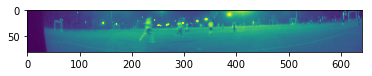

In [9]:
plt.imshow(my_image_resize_2(test_img))
plt.show()

In [10]:
my_image_resize_2(test_img).shape

(80, 640)

In [11]:
get_rows = 1000
# get sizes of image data 
m = data.shape[0]
image_size = [80,640]#test_img.shape
# total size of numpy volume
data_size = [get_rows, *image_size]

## Fetch images an calculate delta images

In [12]:
# fill numpy volume with image data
data_np = np.zeros(data_size)
count = 0
prev_img = None
for i, v in data[:get_rows].iterrows():

    if np.isnan(v['y']) == False:
        
        if not(count % 100):
            print(count)

        new_img = my_image_resize_2(misc.imread(IMAGE_PATH + i, flatten=True))
        if prev_img is not None:
            delta_img = np.clip((prev_img - new_img),a_min=0, a_max=1)
            data_np[count,:,:] =  delta_img
        prev_img = new_img
        count += 1

0
100
200
300
400
500
600
700
800
900


In [13]:
data_np[9]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00835685,  0.        ],
       [ 0.00279216,  0.00392157,  0.        , ...,  0.        ,
         0.        ,  0.00901568],
       [ 0.        ,  0.00392157,  0.        , ...,  0.00760785,
         0.00117254,  0.        ],
       ..., 
       [ 0.        ,  0.00089412,  0.00089412, ...,  0.        ,
         0.00856864,  0.        ],
       [ 0.00061569,  0.00364314,  0.00392157, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00505099,  0.        , ...,  0.00166273,
         0.        ,  0.        ]])

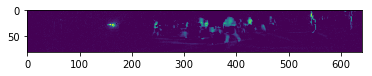

In [14]:
plt.imshow(data_np[20])
plt.show()

In [15]:
data_np.shape

(1000, 80, 640)

In [16]:
# np.save('data/numpy_images/d1.npy', data_np)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = data_np.reshape([*data_np.shape,1])
y = data.dropna()[:get_rows]/640

# skip first image as it had no previous image an therefore delta was not calculated
X = X[1:]
y = y[1:]

In [19]:
def print_image_labels(images, labels):
    for i,(p,) in enumerate(labels):
        print(p,i )
        temp_img = np.copy(images[i].reshape(images[3].shape[:-1]))
        pred_col = int(temp_img.shape[1]*p)
        temp_img[:, pred_col:pred_col+5] = 1
        print(pred_col)
        plt.imshow(temp_img)
        plt.show()

In [20]:
def print_image_labels_comp(images, labels, preds=None):
    for i,(p,) in enumerate(labels):
        print(p,i )
        temp_img = np.copy(images[i].reshape(images[3].shape[:-1]))
        lab = int(temp_img.shape[1]*p)
        pred = int(temp_img.shape[1]*preds[i])
        temp_img[:, lab:lab+5] = 1
        temp_img[:, pred:pred+5] = 0.5
        print(lab, pred)
        plt.imshow(temp_img)
        plt.show()

0.525 0
336


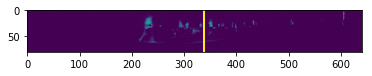

0.5734375 1
367


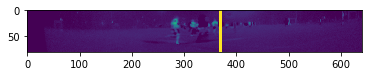

0.6125 2
392


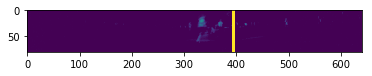

0.6265625 3
401


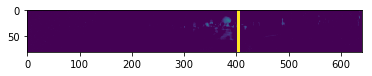

0.646875 4
414


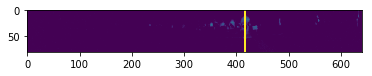

0.63125 5
404


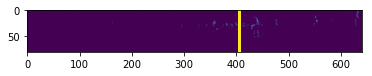

0.621875 6
398


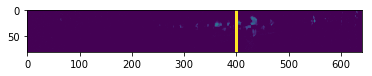

0.6640625 7
425


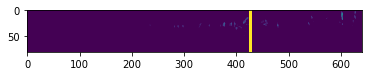

0.6609375 8
423


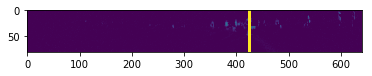

0.6171875 9
395


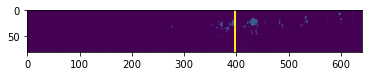

In [21]:
print_image_labels(X[:10], y[:10].values)

## Define and train network

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import optimizers

Using TensorFlow backend.


In [23]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(80, 640, 1)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))

In [24]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [25]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print(x_train.shape, x_test.shape)

(799, 80, 640, 1) (200, 80, 640, 1)


In [26]:
model.fit(x_train, y_train,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 799 samples, validate on 200 samples
Epoch 1/5
799/799 [==============================] - 13s 16ms/step - loss: 1.2545 - val_loss: 0.0341
Epoch 2/5
799/799 [==============================] - 13s 16ms/step - loss: 0.0393 - val_loss: 0.0241
Epoch 3/5
799/799 [==============================] - 13s 17ms/step - loss: 0.0287 - val_loss: 0.0186
Epoch 4/5
799/799 [==============================] - 14s 17ms/step - loss: 0.0386 - val_loss: 0.0204
Epoch 5/5
799/799 [==============================] - 13s 17ms/step - loss: 0.0237 - val_loss: 0.0158


## Show predictions

In [27]:
preds = model.predict(x_test[:10])

0.29375 0
188 211


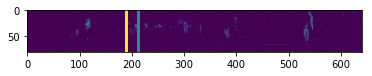

0.5765625 1
369 477


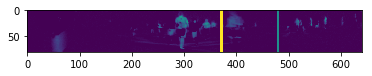

0.1890625 2
121 280


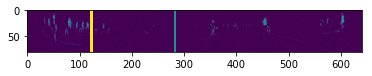

0.696875 3
446 520


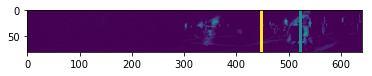

0.7703125 4
493 508


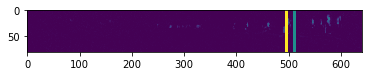

0.74375 5
476 463


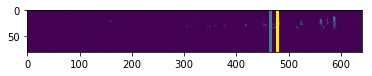

0.178125 6
114 116


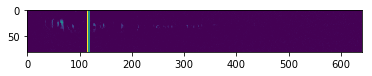

0.5203125 7
333 376


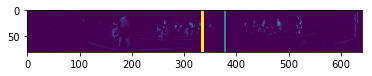

0.4234375 8
271 256


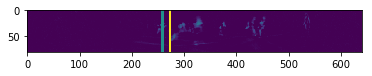

0.8109375 9
519 544


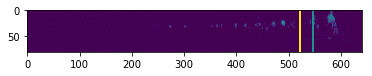

In [28]:
print_image_labels_comp(x_test[:10], y_test.values[:10],preds[:10])
# actual labels are yellow, predictions are blue

In [29]:
model.count_params()

12741921

In [30]:
import h5py

In [31]:
model.save('cnn_delta_80_640.h5')

In [32]:
np.save('test_delta_data',x_test)